In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
import dotenv


os.chdir(dotenv.find_dotenv().replace('.env', ''))
from pseudobatch import pseudobatch_transform, shift

In [2]:
fedbatch_file = os.path.join("tests", "test_data", "fed-batch3.csv")
fedbatch_df = pd.read_csv(fedbatch_file, index_col=0).drop_duplicates(subset='timestamp', keep='first') # ODE solver save both data before and after sampling event

In [3]:
# Calculating the concentrations
fedbatch_df['c_Biomass'] = fedbatch_df['m_Biomass'] /  fedbatch_df['v_volume']
fedbatch_df['c_Glucose'] = fedbatch_df['m_Glucose'] /  fedbatch_df['v_volume']
fedbatch_df['c_CO2'] = fedbatch_df['m_CO2'] /  fedbatch_df['v_volume']
fedbatch_df

,m_Glucose,m_Biomass,m_Ethanol,m_CO2,v_volume,v_feed_accum,timestamp,sample_volume,True growth rate,c_Biomass,c_Glucose,c_CO2
0,0.000000,288.000000,0.0,0.000000e+00,800.000000,0.000000,0.000000,NaN,0.000000,0.360000,0.000000,0.000000e+00
1,0.001414,288.000000,0.0,6.749071e-10,800.000015,0.000015,0.000013,NaN,0.000004,0.360000,0.000002,8.436338e-13
2,0.015553,288.000001,0.0,8.164807e-08,800.000166,0.000166,0.000146,NaN,0.000039,0.360000,0.000019,1.020601e-10
3,0.156673,288.000083,0.0,8.298003e-06,800.001674,0.001674,0.001472,NaN,0.000391,0.359999,0.000196,1.037248e-08
4,1.542043,288.008157,0.0,8.157389e-04,800.016771,0.016771,0.014729,NaN,0.003806,0.360003,0.001928,1.019652e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
288,76.646621,17481.700420,0.0,1.736147e+03,1020.682526,820.682526,49.806637,NaN,0.100083,17.127461,0.075093,1.700966e+00
289,76.968431,17590.184599,0.0,1.746995e+03,1024.971754,824.971754,49.868477,NaN,0.100083,17.161629,0.075093,1.704433e+00
290,77.291593,17699.124516,0.0,1.757889e+03,1029.279000,829.279000,49.930195,NaN,0.100083,17.195653,0.075093,1.707884e+00
291,77.616115,17808.522086,0.0,1.768829e+03,1033.604341,833.604341,49.991791,NaN,0.100082,17.229535,0.075093,1.711321e+00


## Do pseudo batch transformation

In [4]:
species_to_correct = ["c_Biomass", "c_Glucose", "c_CO2"]
concentration_in_feed = [0, 93.75, 0]

for (species, conc) in zip(species_to_correct, concentration_in_feed):
    species_name = species.split('_')[1]
    fedbatch_df['pseudo_'+species_name] = pseudobatch_transform(
                measured_concentration=fedbatch_df[species].to_numpy(),
                reactor_volume=fedbatch_df['v_volume'].to_numpy(),
                accumulated_feed=fedbatch_df['v_feed_accum'].to_numpy(),
                concentration_in_feed=conc,
                sample_volume=fedbatch_df['sample_volume'].fillna(0).to_numpy() # the sample volume column contains nan when at times where no sample was taken
            )        
fedbatch_df

,m_Glucose,m_Biomass,m_Ethanol,m_CO2,v_volume,v_feed_accum,timestamp,sample_volume,True growth rate,c_Biomass,c_Glucose,c_CO2,pseudo_Biomass,pseudo_Glucose,pseudo_CO2
0,0.000000,288.000000,0.0,0.000000e+00,800.000000,0.000000,0.000000,NaN,0.000000,0.360000,0.000000,0.000000e+00,0.360000,0.000000e+00,0.000000e+00
1,0.001414,288.000000,0.0,6.749071e-10,800.000015,0.000015,0.000013,NaN,0.000004,0.360000,0.000002,8.436338e-13,0.360000,-3.124570e-11,8.436338e-13
2,0.015553,288.000001,0.0,8.164807e-08,800.000166,0.000166,0.000146,NaN,0.000039,0.360000,0.000019,1.020601e-10,0.360000,-3.780003e-09,1.020601e-10
3,0.156673,288.000083,0.0,8.298003e-06,800.001674,0.001674,0.001472,NaN,0.000391,0.359999,0.000196,1.037248e-08,0.360000,-3.841668e-07,1.037250e-08
4,1.542043,288.008157,0.0,8.157389e-04,800.016771,0.016771,0.014729,NaN,0.003806,0.360003,0.001928,1.019652e-06,0.360010,-3.776569e-05,1.019674e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,76.646621,17481.700420,0.0,1.736147e+03,1020.682526,820.682526,49.806637,NaN,0.100083,17.127461,0.075093,1.700966e+00,52.343583,-1.925318e+02,5.198358e+00
289,76.968431,17590.184599,0.0,1.746995e+03,1024.971754,824.971754,49.868477,NaN,0.100083,17.161629,0.075093,1.704433e+00,52.668406,-1.937348e+02,5.230841e+00
290,77.291593,17699.124516,0.0,1.757889e+03,1029.279000,829.279000,49.930195,NaN,0.100083,17.195653,0.075093,1.707884e+00,52.994593,-1.949429e+02,5.263459e+00
291,77.616115,17808.522086,0.0,1.768829e+03,1033.604341,833.604341,49.991791,NaN,0.100082,17.229535,0.075093,1.711321e+00,53.322150,-1.961561e+02,5.296215e+00


<AxesSubplot:xlabel='timestamp', ylabel='pseudo_Biomass'>

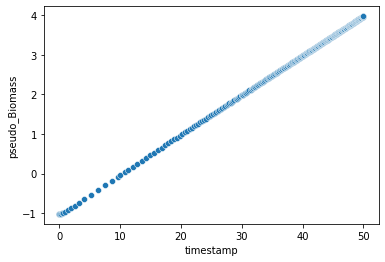

In [5]:
sns.scatterplot( x=fedbatch_df['timestamp'], y=fedbatch_df['pseudo_Biomass'].transform(np.log))

<AxesSubplot:xlabel='timestamp', ylabel='pseudo_Glucose'>

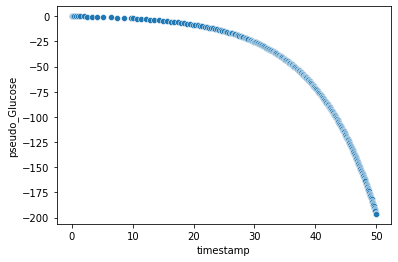

In [6]:
sns.scatterplot( x=fedbatch_df['timestamp'], y=fedbatch_df['pseudo_Glucose'])